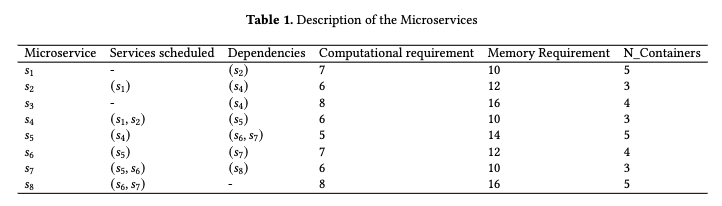

In [ ]:
# Set of services to be scheduled, including dependencies, computational requirement,
# memory requirement and number of containers
services = {
    "1":{"prev": [], "connections":["2"], "cal": 7, "str": 10, "container": 5},
    "2":{"prev": ["1"], "connections":["4"], "cal": 6, "str": 12, "container": 3},
    "3":{"prev": [], "connections":["4"], "cal": 8, "str": 16, "container": 4},
    "4":{"prev": ["2", "3"], "connections":["5"], "cal": 6, "str": 10, "container": 3},
    "5":{"prev": ["4"],"connections":["6", "7"],"cal": 5, "str": 14, "container": 5},
    "6":{"prev": ["5"], "connections":["7"], "cal": 7, "str": 12, "container": 4},
    "7":{"prev": ["5", "6"], "connections":["8"], "cal": 6, "str": 10, "container": 3},
    "8":{"prev": ["6", "7"], "connections":[], "cal": 8, "str": 16, "container": 5}
}

# Set of nodes to schedule to, including computational capacity, memory capacity,
# and fail rate
nodes = {
    "1":{"max_cal": 70, "max_str": 100, "fail": 0.4},
    "2":{"max_cal": 60, "max_str": 110, "fail": 0.01},
    "3":{"max_cal": 80, "max_str": 90, "fail": 0.03},
    "4":{"max_cal": 90, "max_str": 120, "fail": 0.02},
    "5":{"max_cal": 70, "max_str": 80, "fail": 0.05},
    "6":{"max_cal": 90, "max_str": 100, "fail": 0.04},
    "7":{"max_cal": 50, "max_str": 110, "fail": 0.02},
    "8":{"max_cal": 80, "max_str": 120, "fail": 0.06},
    "9":{"max_cal": 60, "max_str": 130, "fail": 0.03},
    "10":{"max_cal": 50, "max_str": 100, "fail": 0.02},
}


In [ ]:
 from beautifultable import BeautifulTable
import warnings

data = []

for i in range(1,9):
  row = [i]
  row += list(services[str(i)].values())
  data.append(row)

table = BeautifulTable()
table.column_headers = ["Microservice", "Scheduled services","Dependencies","CPU", "Mem", "n_containers"]

for i in range(len(data)):
  table.append_row(data[i])

warnings.filterwarnings("ignore")
print(table)

+--------------+--------------------+--------------+-----+-----+--------------+
| Microservice | Scheduled services | Dependencies | CPU | Mem | n_containers |
+--------------+--------------------+--------------+-----+-----+--------------+
|      1       |         []         |    ['2']     |  7  | 10  |      5       |
+--------------+--------------------+--------------+-----+-----+--------------+
|      2       |       ['1']        |    ['4']     |  6  | 12  |      3       |
+--------------+--------------------+--------------+-----+-----+--------------+
|      3       |         []         |    ['4']     |  8  | 16  |      4       |
+--------------+--------------------+--------------+-----+-----+--------------+
|      4       |     ['2', '3']     |    ['5']     |  6  | 10  |      3       |
+--------------+--------------------+--------------+-----+-----+--------------+
|      5       |       ['4']        |  ['6', '7']  |  5  | 14  |      5       |
+--------------+--------------------+---

##Failure probability for each node

In [ ]:
# Taking Failure probab as another hueristic

print(f'Failure Probabilities\n')
print(f'Node \t\tFailure')
print(f'-------------------------')
for i in range(1,11):
  print(f'Node {i}: \t{list(nodes[str(i)].values())[2]}')

Failure Probabilities

Node 		Failure
-------------------------
Node 1: 	0.4
Node 2: 	0.01
Node 3: 	0.03
Node 4: 	0.02
Node 5: 	0.05
Node 6: 	0.04
Node 7: 	0.02
Node 8: 	0.06
Node 9: 	0.03
Node 10: 	0.02


#Implementing ACO

In [ ]:
import numpy as np

# Initialize pheromone matrix
pheromones = np.ones((len(services), len(nodes))) * 0.1

# Turn service set into list
added = set()
service_list = []
while len(service_list) < len(services.items()):
    for service in services.keys():
        service_name = str(service)
        prev = set(services[service]["prev"])
        if service_name not in added and prev.issubset(added):
            service_list.append(service_name)
    added.update(service_list)

print(service_list)

#Turn nodes set into list
node_list = [str(node) for node in nodes.keys()]

print(node_list)

#Record the best scheduling, cost, and remaining resources
best_path = []
best_cost = 9999
best_remaining = []

#Record the worst scheduling, cost, and remaining resources
worst_cost = 0
worst_path = []
worst_remaining = []

#Run for 100 iterations with 16 an
num_iterations = 100
num_ants = 16

avg_cost = 0
count = 0

#Repeat for num_iterations
for iter in range(num_iterations):

  #Collect each ants scheduling and cost
  ant_path = []
  ant_cost = []

  #For each ant
  for ant in range(num_ants):

    # A list of assigned containers for each node
    assign_list = [[] for node in node_list]

    # Keep track of how many available resources there are
    avail = [(nodes[str(node)]["max_cal"], nodes[str(node)]["max_str"]) for node in node_list]

    #For each service
    for service in service_list:

      #Hold probability for each node
      probabilities = np.zeros(len(node_list))

      #For each container in microservice
      for container in range(services[service]["container"]):

        #Calcualte probabilities to send to each node
        for node in range(len(node_list)):

          #Get remaining processing and stroage units
          r_cal, r_str = avail[node]

          #Get pheremoone associated with service to each node
          pheromone = pheromones[int(service) - 1][node]

          #Calculate hueristic based on resources availbility and fail rate
          heuristic = 1 / (1 + (r_str + r_cal)/(nodes[str(node + 1)]["max_str"] + nodes[str(node + 1)]["max_cal"])) #* (1 - nodes[str(node + 1)]["fail"]))

          #Calculate probability using pheromone and heuristic of single node
          probabilities[node] = (pheromone ** 2) / (heuristic ** 3)

        #Get final probaility over all the nodes
        probabilities /= np.sum(probabilities)

        #Choose random node based on probabilities
        node = np.random.choice(node_list, p = probabilities)
        r_cal, r_str = avail[int(node) - 1]

        #Check if possible to schedule to the node
        while r_cal <= services[service]["cal"] or r_str <= services[service]["str"]:
          #Choose again if not possible
          node = np.random.choice(node_list, p = probabilities)
          r_cal, r_str = avail[int(node) - 1]

        #After node chosen, schedule service onto node
        assign_list[int(node) - 1].append(service)

        #Update available ressources for that node
        avail[int(node) - 1] = tuple(np.subtract(avail[int(node) - 1], (services[service]["cal"], services[service]["str"])))


    #Calculate costs of the scheduling
    total_cost = 0
    max_cost = 0
    min_cost = 9999

    #For each node
    for node in range(len(avail)):
      #Get remaining resource, max resources, and fail rate
      r_cal, r_str = avail[node]
      max_cal = nodes[str(node + 1)]["max_cal"]
      max_str = nodes[str(node + 1)]["max_str"]
      fail = nodes[str(node + 1)]["fail"]

      #Calculate cost by how well resource is utilized while also considering fail rate
      cost = ((r_cal + r_str)/(max_cal + max_str)) * (1 - fail)

      #Add to total cost for schedule
      total_cost += cost

      #Update the highset and lowest cost
      if cost < min_cost:
        min_cost = cost
      if cost > max_cost:
        max_cost = cost

    #Update total cost based on difference of highest and lowest cost, to control the load balance
    total_cost = total_cost * (max_cost - min_cost)

    #Add to keep track of avg cost of all iterations
    avg_cost += total_cost

    #Add to sets of computed ants and ant costs
    ant_path.append(assign_list)
    ant_cost.append(total_cost)

    #Save the best and worst schedules found
    if total_cost < best_cost:
      best_path = [(index + 1, assign_list[index])for index in range(len(assign_list))]
      best_cost = total_cost
      best_remaining = [(index + 1, avail[index])for index in range(len(avail))]
    if total_cost > worst_cost:
      worst_path = [(index + 1, assign_list[index])for index in range(len(assign_list))]
      worst_cost = total_cost
      worst_remaining = [(index + 1, avail[index])for index in range(len(avail))]

  #Update the pheromones based on the cost calculated at all iterations
  pheromones *= 0.5
  for path, cost in zip(ant_path, ant_cost):
    for j in range(len(path)):
      for i in path[j]:
        pheromones[int(i) - 1][j] += 1/cost

#Calauclate averga cost across all iteratios of ants
avg_cost /= (num_iterations * num_ants)

In [ ]:
#Get and idea of the in final probabilites
probabilities /= np.sum(probabilities)


print(f'Probabilities assigned\n')
print(f'Node \t\tProbability')
print(f'-----------------------------------')
for i in range(10):
  print(f'Node {i}: \t{probabilities[i]}')

Probabilities assigned

Node 		Probability
-----------------------------------
Node 0: 	4.07835594598694e-59
Node 1: 	1.435406784324153e-58
Node 2: 	9.56130306064339e-62
Node 3: 	1.8603034469231554e-56
Node 4: 	3.4726766220276855e-60
Node 5: 	1.0
Node 6: 	1.118865043038104e-62
Node 7: 	2.3453996383207157e-60
Node 8: 	1.8333752492454759e-59
Node 9: 	1.3088501605166795e-60


In [ ]:
#Get an idea of the final pheromones
print(f'Pheromones\n')

with np.printoptions(precision=3, suppress=True):
    print(np.array(pheromones))


Pheromones

[[ 0.     0.     0.     0.    43.922  0.     0.     0.     0.     0.   ]
 [ 0.    26.353  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    35.137  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    26.353  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.    43.922]
 [ 0.     0.    35.137  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    26.353  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.    43.922  0.     0.     0.     0.   ]]


In [ ]:
#List out total available resources for each ndoe
avail = [(int(node), (nodes[str(node)]["max_cal"], nodes[str(node)]["max_str"])) for node in node_list]


print(f'Total Available Resources\n')
print(f'Node \t\tCPU Usage \tMemory Usage')
print(f'----------------------------------------------')
for i, val in avail:
  print(f'Node {i}: \tcpu:{list(nodes[str(i)].values())[0]} \t\tmem:{list(nodes[str(i)].values())[1]}')

Total Available Resources

Node 		CPU Usage 	Memory Usage
----------------------------------------------
Node 1: 	cpu:70 		mem:100
Node 2: 	cpu:60 		mem:110
Node 3: 	cpu:80 		mem:90
Node 4: 	cpu:90 		mem:120
Node 5: 	cpu:70 		mem:80
Node 6: 	cpu:90 		mem:100
Node 7: 	cpu:50 		mem:110
Node 8: 	cpu:80 		mem:120
Node 9: 	cpu:60 		mem:130
Node 10: 	cpu:50 		mem:100


#Analyzing Outcomes

##Worst Case Scenario

In [ ]:
#Print the worst calculated schedule cost
print(f'1. Worst Cost: {worst_cost}\n')


#Print the schedule
print(f'\n2. Microservices Assigned\n')
print(f'Node \t\tScheduled')
print(f'----------------------------------------------')
for i in worst_path:
  print(f'Node {i[0]}: \t{i[1]} ')


#Print the remaining resources of the nodes
print(f'\n\n3. Remaining Resources Summary\n')
print(f'Node \t\tCPU Usage \tMemory Usage')
print(f'----------------------------------------------')
for i, val in worst_remaining:
  print(f'Node {i}: \tcpu:{val[0]}/{list(nodes[str(i)].values())[0]} \tmem:{val[1]}/{list(nodes[str(i)].values())[1]}')

1. Worst Cost: 5.037320440718954


2. Microservices Assigned

Node 		Scheduled
----------------------------------------------
Node 1: 	[] 
Node 2: 	['2', '2'] 
Node 3: 	['6'] 
Node 4: 	[] 
Node 5: 	['1', '1', '1', '1', '1'] 
Node 6: 	['8', '8', '8', '8', '8'] 
Node 7: 	['6', '7', '7', '7'] 
Node 8: 	['3', '3', '3', '3', '2'] 
Node 9: 	['4', '4', '4'] 
Node 10: 	['5', '5', '5', '5', '5', '6', '6'] 


3. Remaining Resources Summary

Node 		CPU Usage 	Memory Usage
----------------------------------------------
Node 1: 	cpu:70/70 	mem:100/100
Node 2: 	cpu:48/60 	mem:86/110
Node 3: 	cpu:73/80 	mem:78/90
Node 4: 	cpu:90/90 	mem:120/120
Node 5: 	cpu:35/70 	mem:30/80
Node 6: 	cpu:50/90 	mem:20/100
Node 7: 	cpu:25/50 	mem:68/110
Node 8: 	cpu:42/80 	mem:44/120
Node 9: 	cpu:42/60 	mem:100/130
Node 10: 	cpu:11/50 	mem:6/100


##Average Case Scenario

In [ ]:
print(avg_cost)

3.5981702373099695


##Best Case Scenario

In [ ]:
#Print cost of best calculated path
print(f'1. Best Cost: {best_cost}\n')


#Print the service schedule
print(f'\n2. Microservices Assigned\n')
print(f'Node \t\tScheduled')
print(f'----------------------------------------------')
for i in best_path:
  print(f'Node {i[0]}: \t{i[1]} ')


#Print the remaining resouces of each node
print(f'\n\n3. Remaining Resources Summary\n')
print(f'Node \t\tCPU Usage \tMemory Usage')
print(f'----------------------------------------------')
for i, val in best_remaining:
  print(f'Node {i}: \tcpu:{val[0]}/{list(nodes[str(i)].values())[0]} \tmem:{val[1]}/{list(nodes[str(i)].values())[1]}')

1. Best Cost: 1.7310681491179183


2. Microservices Assigned

Node 		Scheduled
----------------------------------------------
Node 1: 	['7'] 
Node 2: 	['2', '5', '5', '8'] 
Node 3: 	['1', '1', '4'] 
Node 4: 	['4', '5', '8', '8'] 
Node 5: 	['1', '1'] 
Node 6: 	['3', '6'] 
Node 7: 	['2', '6', '7', '7'] 
Node 8: 	['3', '3', '3', '2'] 
Node 9: 	['1', '4', '6', '8'] 
Node 10: 	['5', '5', '6', '8'] 


3. Remaining Resources Summary

Node 		CPU Usage 	Memory Usage
----------------------------------------------
Node 1: 	cpu:64/70 	mem:90/100
Node 2: 	cpu:36/60 	mem:54/110
Node 3: 	cpu:60/80 	mem:60/90
Node 4: 	cpu:63/90 	mem:64/120
Node 5: 	cpu:56/70 	mem:60/80
Node 6: 	cpu:75/90 	mem:72/100
Node 7: 	cpu:25/50 	mem:66/110
Node 8: 	cpu:50/80 	mem:60/120
Node 9: 	cpu:32/60 	mem:82/130
Node 10: 	cpu:25/50 	mem:44/100


#Calculating Overall Utilization




## Worst Case Scenario

In [ ]:
#Calculate utilization rate from worst computed schedule
utilization_rate = [(node, 1 - (cal + mem)/(nodes[str(node)]["max_cal"] + nodes[str(node)]["max_str"])) for (node, (cal, mem)) in worst_remaining]

In [ ]:
#Print utilization rate for each node from best computed schedule.
print(f'Total Utilization Rate for each Node\n')
print(f'Node \t\tUtilization')
print(f'-----------------------------------')
for i, util in utilization_rate:
  print(f'Node {i}: \t{util}')

Total Utilization Rate for each Node

Node 		Utilization
-----------------------------------
Node 1: 	0.0
Node 2: 	0.21176470588235297
Node 3: 	0.11176470588235299
Node 4: 	0.0
Node 5: 	0.5666666666666667
Node 6: 	0.631578947368421
Node 7: 	0.41874999999999996
Node 8: 	0.5700000000000001
Node 9: 	0.25263157894736843
Node 10: 	0.8866666666666667


## Best Case Scenario

In [ ]:
#Calculate utilization rate from best computed schedule
utilization_rate = [(node, 1 - (cal + mem)/(nodes[str(node)]["max_cal"] + nodes[str(node)]["max_str"])) for (node, (cal, mem)) in best_remaining]

In [ ]:
#Print utilization rate for each node from best computed schedule.
print(f'Total Utilization Rate for each Node\n')
print(f'Node \t\tUtilization')
print(f'-----------------------------------')
for i, util in utilization_rate:
  print(f'Node {i}: \t{util}')

Total Utilization Rate for each Node

Node 		Utilization
-----------------------------------
Node 1: 	0.09411764705882353
Node 2: 	0.47058823529411764
Node 3: 	0.2941176470588235
Node 4: 	0.3952380952380953
Node 5: 	0.22666666666666668
Node 6: 	0.22631578947368425
Node 7: 	0.43125
Node 8: 	0.44999999999999996
Node 9: 	0.4
Node 10: 	0.54


In [ ]:
#Print the average utilization of the nodes
total_utilization = 0
for _, util in utilization_rate:
  total_utilization += util/10
print(total_utilization)

0.352829408079021
